## Logistic Regression ##
Logistic Regression is a supervised algorithm used for classification tasks when aiming to predict the probability of the occurrence of an event.
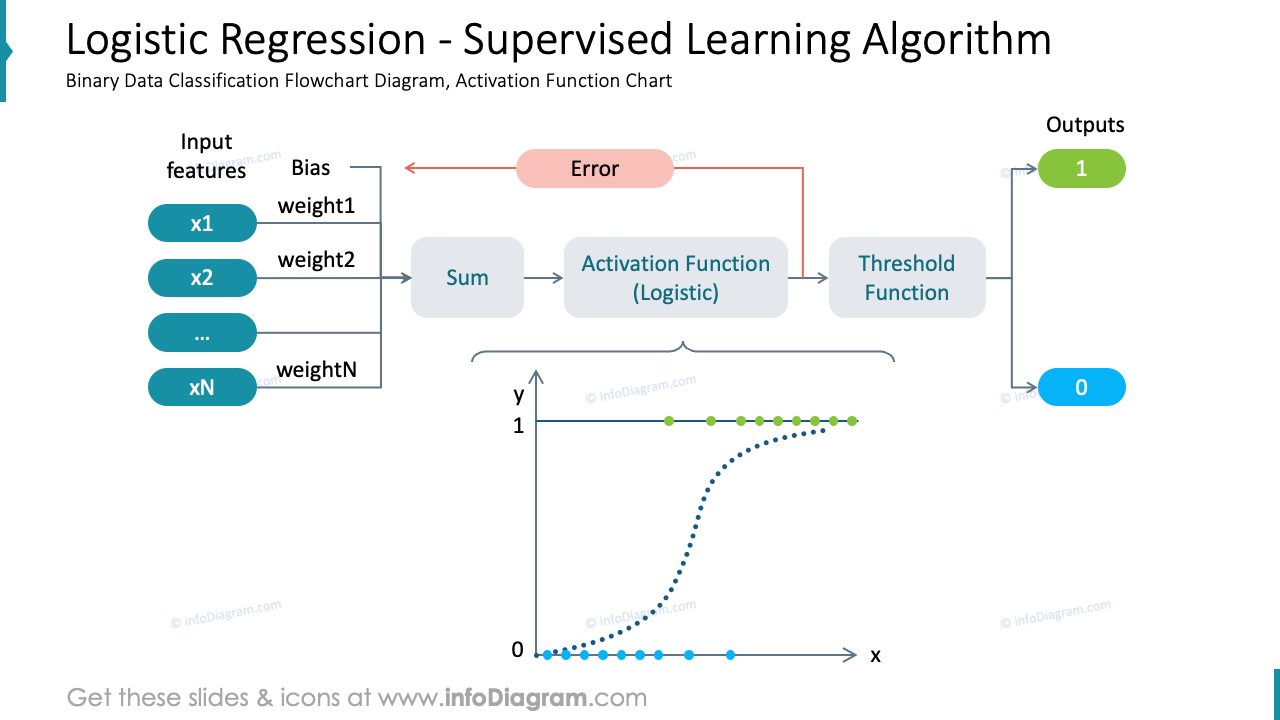

In this section, we explore logistic regression through a hands-on implementation using a custom single-neuron model. We analyze a heart disease dataset to predict the likelihood of heart disease.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Import a nice function for plotting decision boudaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Read the heart disease dataset into a pandas DataFrame object with seaborn
df = pd.read_csv("Datasets/heart.csv")
# Create subsets depending on 'target' outcome
# 0 = No disease, 1 = Disease
no_disease = df[df['target'] == 0]
disease = df[df['target'] == 1]

python(71631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


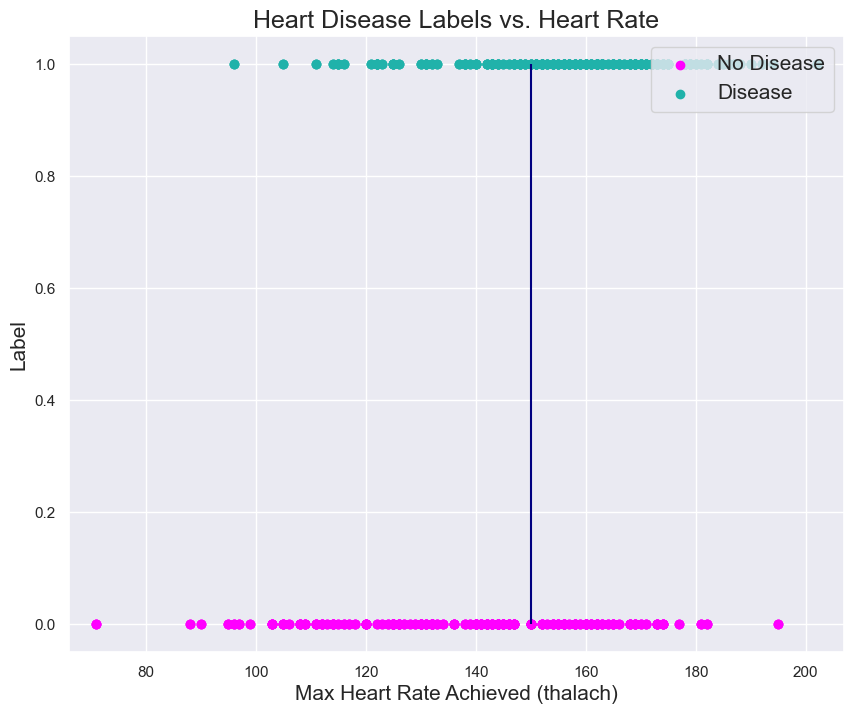

In [2]:
plt.figure(figsize=(10, 8))
plt.xlim((df['thalach'].min() - 5, df['thalach'].max() + 5))

# Plot 0s and 1s manually for illustration
plt.scatter(no_disease['thalach'], np.zeros(len(no_disease)), color="magenta", label="No Disease")
plt.scatter(disease['thalach'], np.ones(len(disease)), color="lightseagreen", label="Disease")


plt.vlines(x=150, ymin=0, ymax=1, color='navy')

plt.xlabel("Max Heart Rate Achieved (thalach)", fontsize=15)
plt.ylabel("Label", fontsize=15)
plt.legend(fontsize=15, loc="upper right")
plt.title("Heart Disease Labels vs. Heart Rate", fontsize=18)
plt.show()

In this plot above, we visualized the relationship between maximum heart rate achieved (thalach) and the presence or absence of heart disease (target). Each point represents a patient:

Patients without heart disease (target = 0) are shown in magenta.

Patients with heart disease (target = 1) are shown in lightseagreen.

We manually assigned y-values of 0 and 1 to make the plot easy to interpret, and draw a vertical line at thalach = 150 as a possible threshold for separating the two classes.

While this visual helps suggest some separation between the two groups, there is no perfect cutoff which is why we will fit a logistic regression model to learn the best probabilistic decision boundary based on the data and its distribution.

---
Logistic regression uses the sigmoid function to map inputs into probabilities. The plot below will show:
- The relationship between `thalach` and target class
- The sigmoid function $\sigma(z)$ which smoothly transitions between 0 and 1

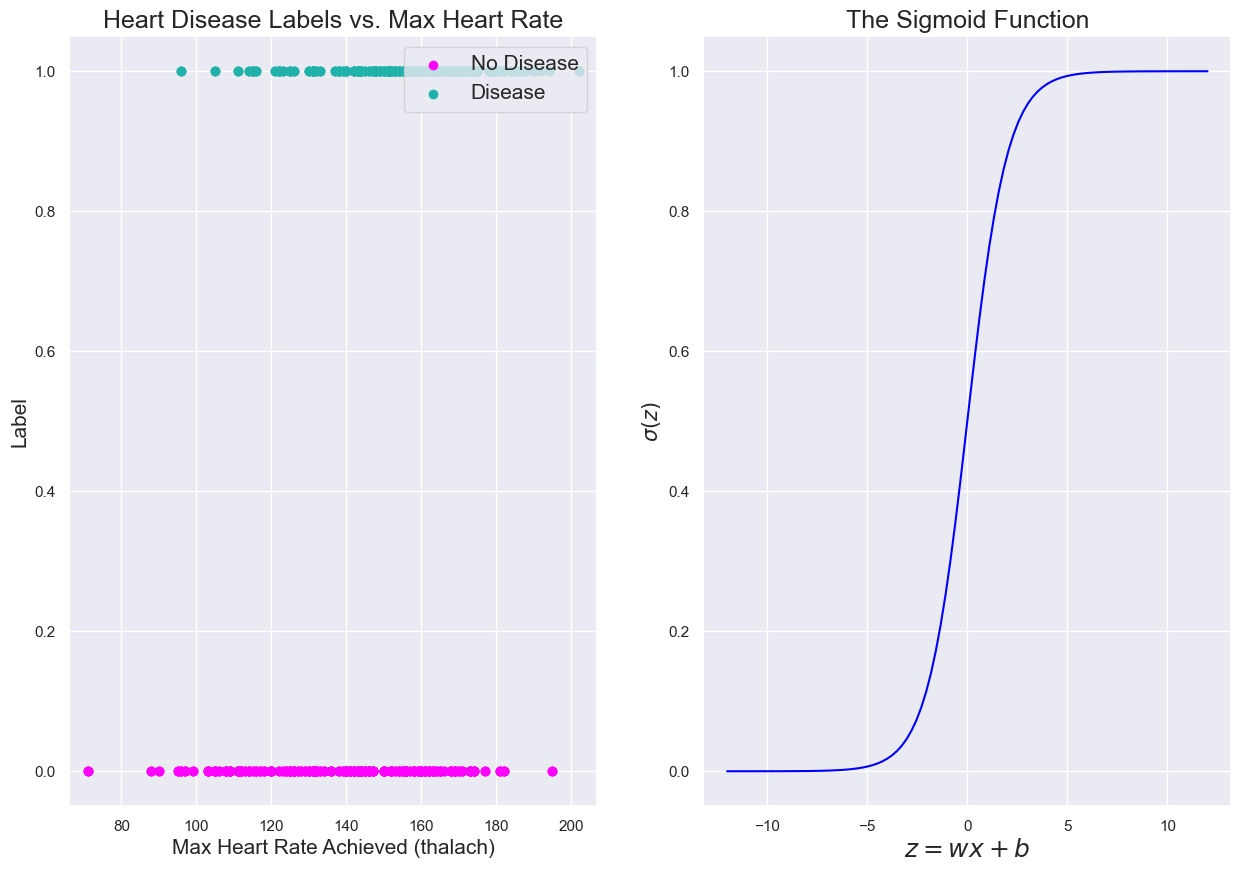

In [3]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Left plot: 1D scatter of thalach vs. labels
ax1.set_xlim((df['thalach'].min() - 5, df['thalach'].max() + 5))
ax1.scatter(no_disease['thalach'], 
            np.zeros(len(no_disease)), 
            color="magenta", 
            label="No Disease")
ax1.scatter(disease['thalach'], 
            np.ones(len(disease)), 
            color="lightseagreen", 
            label="Disease")
ax1.set_xlabel("Max Heart Rate Achieved (thalach)", fontsize=15)
ax1.set_ylabel("Label", fontsize=15)
ax1.set_title("Heart Disease Labels vs. Max Heart Rate", fontsize=18)
ax1.legend(fontsize=15, loc="upper right")

# Right plot: Sigmoid function
domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, sigmoid(domain), color="blue", label=r"$\sigma(z)$")
ax2.set_xlabel(r"$z = wx + b$", fontsize=18)
ax2.set_ylabel(r"$\sigma(z)$", fontsize=15)
ax2.set_title("The Sigmoid Function", fontsize=18)


plt.show()

The x-axis shows maximum heart rate achieved (thalach), and the y-axis indicates whether the patient was diagnosed with heart disease (target: 0 = no, 1 = yes). This gives us a 1-dimensional classification problem, useful for illustrating the setup of logistic regression.

On the right, we plot the sigmoid function
σ(z), which transforms any input z=wx+b into a probability between 0 and 1. This curve is used in logistic regression to model the probability that a data point belongs to class 1. The smooth transition of the sigmoid is well-suited for datasets that are not perfectly separable.

### Creating Single Neuron Model

This neuron uses stochastic gradient descent to optimize weights and bias based on the sigmoid activation and a selected cost function (MSE or cross-entropy).

In [6]:
class SingleNeuron(object):
    """
    A class used to represent a single artificial neuron. 

    ...

    Attributes
    ----------
    activation_function : function
        The activation function applied to the preactivation linear combination.
    
    cost_function : function
        The cost function used to measure model performance.

    w_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry being the bias. 
        This attribute is created when the train method is called.

    errors_: list
        A list containing the mean sqaured error computed after each iteration 
        of stochastic gradient descent per epoch. 

    Methods
    -------
    train(self, X, y, alpha = 0.005, epochs = 50)
        Iterates the stochastic gradient descent algorithm through each sample 
        a total of epochs number of times with learning rate alpha. The data 
        used consists of feature vectors X and associated labels y. 

    predict(self, X)
        Uses the weights and bias, the feature vectors in X, and the 
        activation_function to make a y_hat prediction on each feature vector. 
    """
    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function
        self.cost_function = cost_function

    def train(self, X, y, alpha = 0.005, epochs = 50):
   
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        N = X.shape[0]

        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X, y):
                #one prediction
                y_hat = self.predict(xi)
                error = (y_hat - target)
                self.w_[:-1] -= alpha*error*xi
                self.w_[-1] -= alpha*error.item()
                ##
                ##errors += .5*((self.predict(xi) - target)**2)
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors/N)
        return self

    def predict(self, X):
        ##
        X=np.atleast_2d(X)
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), 
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

Now we must write a function for the binary cross entropy loss. 
Then we will create an instance of the SingleNeuron class, convert our feature measurements into ```numpy.ndarray```. Then we will create a target $y$ ```numpy.ndarray``` which assigns the labels 0 and 1 to our target variable 

We can then pass these values into the ```SingleNeuron.train()``` method to train our logistic single neuron with stochastic gradient descent.

In [7]:
# Define cross-entropy loss
def cross_entropy_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-10, 1 - (1e-10))
    return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

# Initialize neuron with sigmoid activation and cross-entropy loss
node = SingleNeuron(sigmoid, cross_entropy_loss)

# Use max heart rate (thalach) as input feature
X = df['thalach'].values.reshape(-1, 1)  # 2D shape, get feature as column vector
y = df['target'].values # Labels: 0 = No Disease, 1 = Disease

# Train the logistic regression model
node.train(X, y, alpha=0.0006, epochs=500)

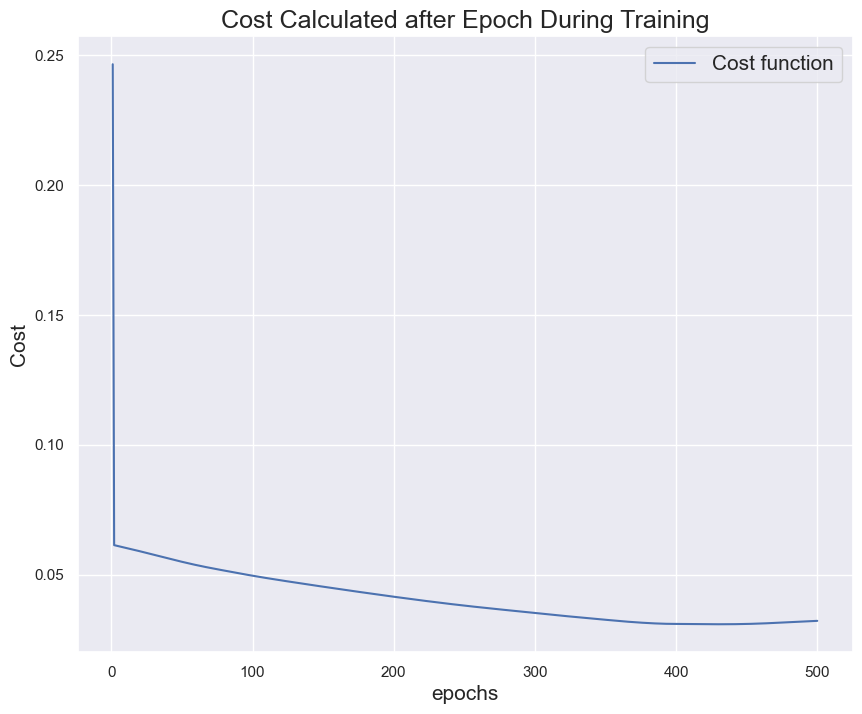

In [8]:
node.plot_cost_function()

Below is my initial cost graph (with learning rate of 0.01)
I kept lowering the learning rate before landing on 0.0006 to receive a smoother graph.

![alt text](image.png)

---
We can now visualize our hypothesis/prediction function.

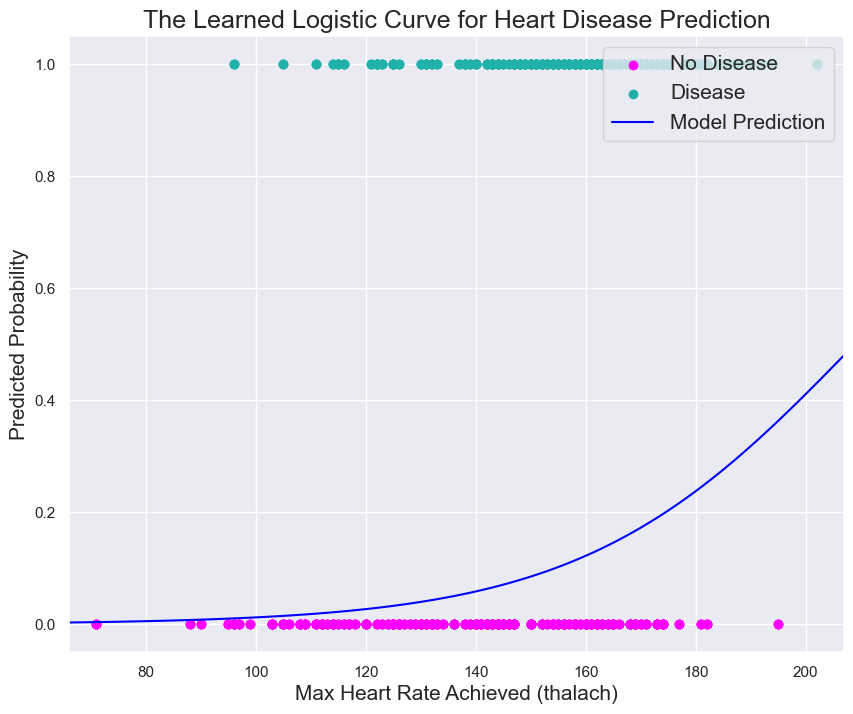

In [9]:
plt.figure(figsize=(10, 8))

# Set x-axis limits based on heart rate data
plt.xlim((df['thalach'].min() - 5, df['thalach'].max() + 5))

# Plot the scattered actual data
plt.scatter(no_disease['thalach'], 
            np.zeros(len(no_disease)), 
            color="magenta", 
            label="No Disease")
plt.scatter(disease['thalach'], 
            np.ones(len(disease)), 
            color="lightseagreen", 
            label="Disease")

# Plot the learned logistic regression curve
domain = np.linspace(df['thalach'].min() - 5, df['thalach'].max() + 5, 100)
plt.plot(domain, node.predict(domain.reshape(-1, 1)), color="blue", label="Model Prediction")

plt.xlabel("Max Heart Rate Achieved (thalach)", fontsize=15)
plt.ylabel("Predicted Probability", fontsize=15)
plt.legend(fontsize=15, loc="upper right")
plt.title("The Learned Logistic Curve for Heart Disease Prediction", fontsize=18)
plt.show()


Here, we overlay the learned sigmoid prediction curve on top of the actual data points to see how well the model fits.

---
### Classification Performance

We compute the classification error by rounding predicted probabilities to the nearest class and comparing with true labels. Error helps evaluate the effectiveness of our learned decision boundary.

In [10]:
node.predict(X)

array([0.16113006, 0.10216659, 0.03287741, ..., 0.02500288, 0.11791839,
       0.02053645])

In [11]:
np.rint(node.predict(X)) != y

array([False, False, False, ..., False,  True, False])

In [12]:
classification_error = (np.rint(node.predict(X)) != y).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y)}")

Classification Error = 0.5131707317073171


---
We can view our decision boundary implied by the trained weights and bias.

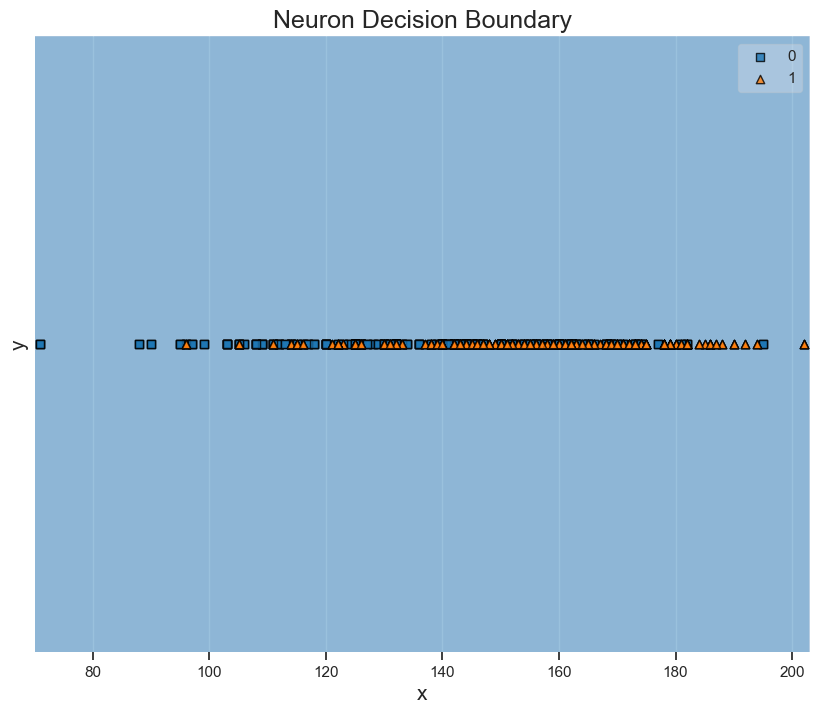

In [13]:
node.plot_decision_boundary(X, y)
plt.show()

### Findings ###
After training the model on the ```thalach``` feature, we evaluated its performance using the ```SingleNeuron.predict()``` method. 
By comparing the predictions to the true values, we found the classfication error rate of about 51%, indicating that the model struggles to differentiate between patients with and without heart disease based on max heart rate.

We can see this further in the decision boundary plot above. The decision boundary is not visible, and the model appears to classify basically everything as class 0 (no disease).
The plot shows that ```thalach``` alone is insufficient for classifying accurately. Including additional features would likely improve the performance of our model.


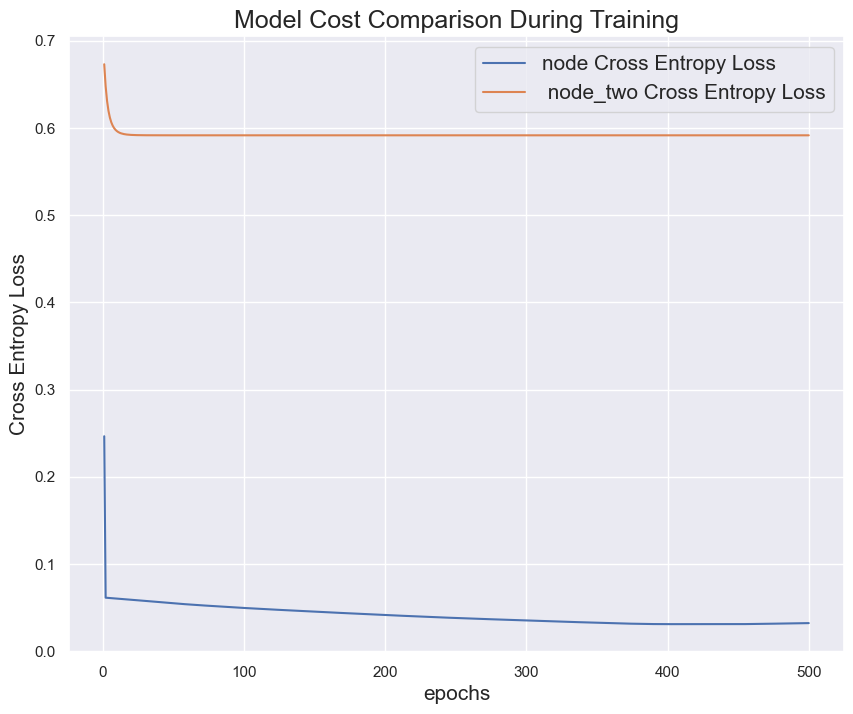

In [14]:
# Instantiate a new single neuron.
node_two = SingleNeuron(sigmoid, cross_entropy_loss)
scaler = StandardScaler()


X_two = df[["thalach", "age"]].values
X_two_scaled = scaler.fit_transform(X_two)
# Train the new single neuron model on the new feature vectors.
node_two.train(X_two_scaled, y, alpha = 0.0006, epochs = 500)


plt.figure(figsize = (10, 8))
plt.plot(range(1, len(node.errors_) + 1), 
         node.errors_,
         label = "node Cross Entropy Loss")
plt.plot(range(1, len(node_two.errors_) + 1), 
         node_two.errors_,
         label = " node_two Cross Entropy Loss")
plt.xlabel("epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)


plt.show()

Here, I experimented with using both `thalach` and `age`, but as seen in the plot it gave a even higher model cost in comparison with the model that just used `thalach`.

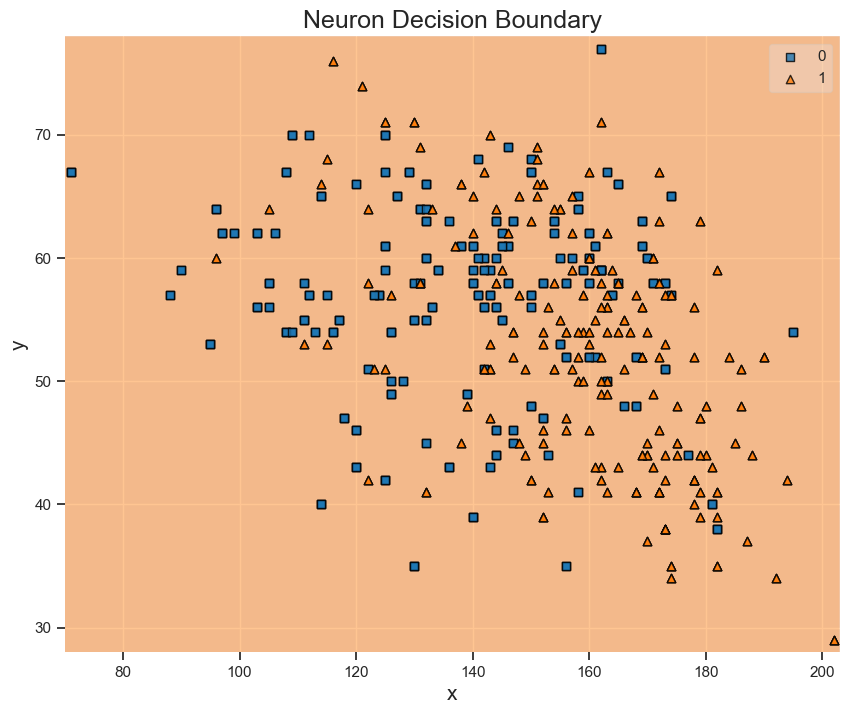

In [15]:
node_two.plot_decision_boundary(X_two, y)

As we can see, there is no visible decision boundary at all.

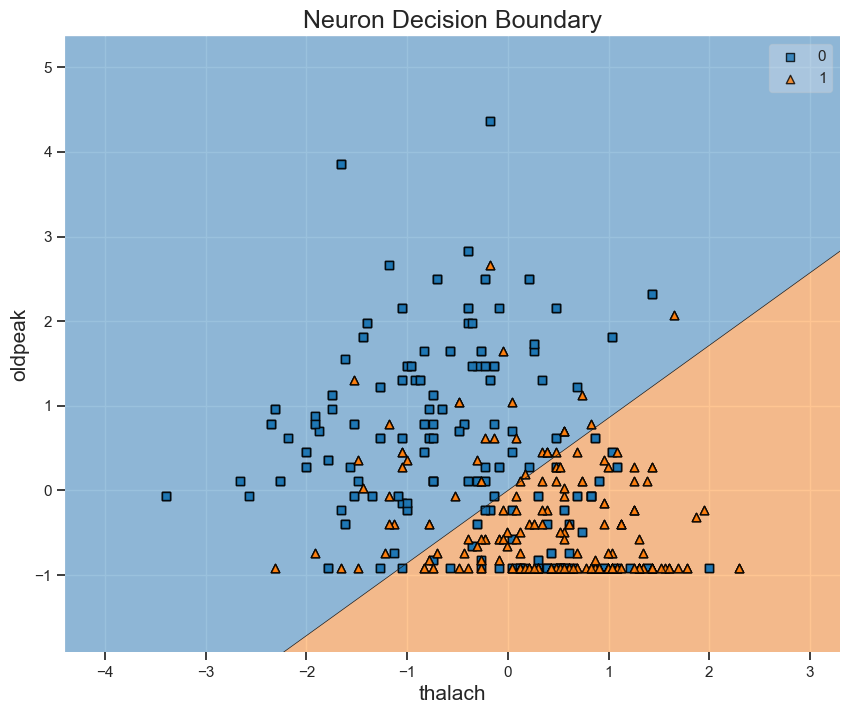

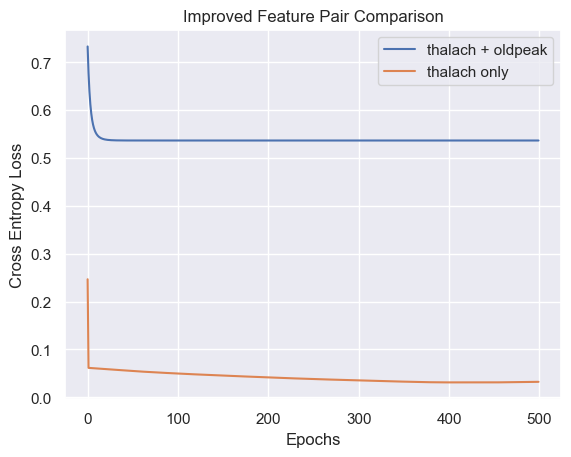

In [16]:
X_better = df[['thalach', 'oldpeak']].values

scaler = StandardScaler()
X_better_scaled = scaler.fit_transform(X_better)

node_better = SingleNeuron(sigmoid, cross_entropy_loss)
node_better.train(X_better_scaled, y, alpha=0.0006, epochs=500)

node_better.plot_decision_boundary(X_better_scaled, y, xstring="thalach", ystring="oldpeak")
plt.show()

# compare cost curves
plt.plot(node_better.errors_, label='thalach + oldpeak')
plt.plot(node.errors_, label='thalach only')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.title("Improved Feature Pair Comparison")
plt.show()

Lastly, I experimented with using both `thalach` and `oldpeak` as inputs, sclaing the features and retraining the model.
This resulted in a sharper, more meaningful decision boundary as seen above. Despite the expectation that adding another feature might improve the model, the cross entropy loss is actually higher for this new combination of features than it is for `thalach` only. 

The cross-entropy loss was consistently higher across all epochs, suggesting that the model using only `thalach` made more accurate predictions. This highlights the importance of feature selection as I observed that not all additional information leads to better results.